In [206]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')

In [207]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

In [208]:
def calculate_flux_density(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_intensity(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

In [209]:
def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

In [210]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [211]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [212]:
with open("BOSS1441_NB.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('nbcut1.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [213]:
with open("BOSS1441_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('bwcut1.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [214]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS1441_Bw=pd.read_csv("BOSS1441_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS1441_NB=pd.read_csv("BOSS1441_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

In [215]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)


SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']


In [216]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
coord_bw=SkyCoord(ra=BOSS1441_Bw['ALPHA_J2000']*u.degree, dec=BOSS1441_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS1441_NB['ALPHA_J2000']*u.degree, dec=BOSS1441_NB['DELTA_J2000']*u.degree)

In [217]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)
index = np.where((d2d < Angle('0d00m0.5s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))
idx=idx[index]

SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj
SDSS6_bmag=SDSS6.bmag.data.obj
BOSS1441_Bw_list=BOSS1441_Bw.MAG_APER.data.obj
BOSS1441_Bw_list_standard=BOSS1441_Bw.MAG_APER.data.obj[idx]


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':


In [218]:
SDSS6_bmag_standard=SDSS6_bmag[index]
zeropoint_bw=SDSS6_bmag_standard-BOSS1441_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

Bw的zeropoint为 25.13518084
Bw的standard deviation为 0.06008385005900087


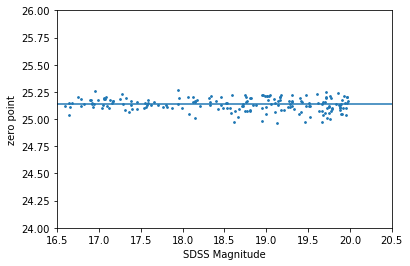

In [219]:
# zeropoint_bw.zeropoint_bw.data.obj
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation


print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)
plt.axis([16.5, 20.5, 24, 26])
plt.show()


In [220]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,BOSS1441_Bw.MAG_APER+zp_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [221]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m02s'))
idx_nb=idx_nb[index_nb]

In [222]:
BOSS1441_NB_match = BOSS1441_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS1441_NB_match < 5) &(BOSS1441_NB_match > 0))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS1441_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS1441_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  


In [223]:
mag_nb_standard_select=sigma_clip(mag_nb_standard_select,sigma=1, iters=10)
zp_nb=np.mean(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))
zp_std_nb=np.std(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':


NB的zeropoint为 22.41070584
NB的standard deviation为 0.00391687056206996


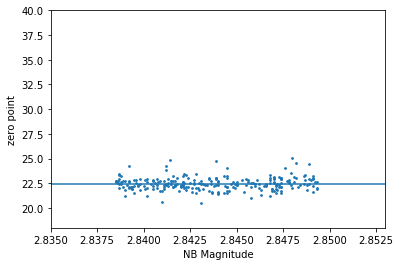

In [224]:
print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

BOSS1441_NB=pd.concat([BOSS1441_NB,BOSS1441_NB.MAG_APER+zp_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

BOSS1441_NB_match=BOSS1441_NB_match+zp_nb

b_nb=BOSS1441_Bw.standard_mag.data.obj[idx_nb]-BOSS1441_NB_match
mag_nb_draw=BOSS1441_NB_match

plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')
plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)
plt.axis([2.835,2.853,18,40])
plt.show()


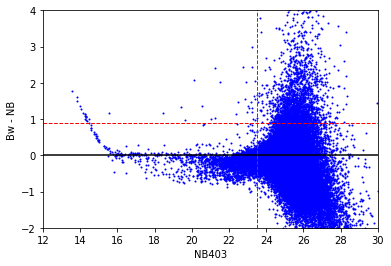

In [225]:
plt.scatter(mag_nb_draw, b_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(23.5, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [226]:
BOSS1441_Bw_ALPHA=BOSS1441_Bw.ALPHA_J2000.data.obj[idx_nb]
BOSS1441_Bw_DELTA=BOSS1441_Bw.DELTA_J2000.data.obj[idx_nb]
BOSS1441_Bw_X_IMAGE=BOSS1441_Bw.X_IMAGE.data.obj[idx_nb]
BOSS1441_Bw_Y_IMAGE=BOSS1441_Bw.Y_IMAGE.data.obj[idx_nb]
BOSS1441_Bw_ISOAREAF_IMAGE=BOSS1441_Bw.ISOAREAF_IMAGE.data.obj[idx_nb]

BOSS1441_NB_ALPHA=BOSS1441_NB.ALPHA_J2000.data.obj[index_nb]
BOSS1441_NB_DELTA=BOSS1441_NB.DELTA_J2000.data.obj[index_nb]
BOSS1441_NB_X_IMAGE=BOSS1441_NB.X_IMAGE.data.obj[index_nb]
BOSS1441_NB_Y_IMAGE=BOSS1441_NB.Y_IMAGE.data.obj[index_nb]
BOSS1441_NB_ISOAREAF_IMAGE=BOSS1441_NB.ISOAREAF_IMAGE.data.obj[index_nb]


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be rem

In [227]:
with open("BOSS1441_Bw.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(idx_nb)):
        if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 23.5):
            txtfile.write('circle(')
            txtfile.write(str(BOSS1441_Bw_ALPHA[i]))
            txtfile.write(',')
            txtfile.write(str(BOSS1441_Bw_DELTA[i]))
            txtfile.write(',2.821")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  


In [228]:
with open("BOSS1441_NB.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(idx_nb)):
        if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 23.5):
            txtfile.write('circle(')
            txtfile.write(str(BOSS1441_NB_ALPHA[i]))
            txtfile.write(',')
            txtfile.write(str(BOSS1441_NB_DELTA[i]))
            txtfile.write(',2.821")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.data is deprecated and will be removed in a future version
  


In [229]:
BOSS1441_Bw_X_IMAGE_dubious=[]
BOSS1441_Bw_Y_IMAGE_dubious=[]
BOSS1441_Bw_RA_dubious=[]
BOSS1441_Bw_DEC_dubious=[]
BOSS1441_Bw_mag_dubious=[]
BOSS1441_Bw_AREA_dubious=[]

BOSS1441_NB_X_IMAGE_dubious=[]
BOSS1441_NB_Y_IMAGE_dubious=[]
BOSS1441_NB_RA_dubious=[]
BOSS1441_NB_DEC_dubious=[]
BOSS1441_NB_mag_dubious=[]
BOSS1441_NB_AREA_dubious=[]

for i in range(len(idx_nb)):
    if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 23.5):
        BOSS1441_Bw_X_IMAGE_dubious.append(BOSS1441_Bw_X_IMAGE[i])
        BOSS1441_Bw_Y_IMAGE_dubious.append(BOSS1441_Bw_Y_IMAGE[i])
        BOSS1441_Bw_RA_dubious.append(BOSS1441_Bw_ALPHA[i])
        BOSS1441_Bw_DEC_dubious.append(BOSS1441_Bw_DELTA[i])
        BOSS1441_Bw_mag_dubious.append(BOSS1441_Bw.standard_mag.data.obj[idx_nb][i])
        BOSS1441_Bw_AREA_dubious.append(BOSS1441_Bw_ISOAREAF_IMAGE[i])
        
        BOSS1441_NB_X_IMAGE_dubious.append(BOSS1441_NB_X_IMAGE[i])
        BOSS1441_NB_Y_IMAGE_dubious.append(BOSS1441_NB_Y_IMAGE[i])
        BOSS1441_NB_RA_dubious.append(BOSS1441_NB_ALPHA[i])
        BOSS1441_NB_DEC_dubious.append(BOSS1441_NB_DELTA[i])
        BOSS1441_NB_mag_dubious.append(BOSS1441_NB_match[i])
        BOSS1441_NB_AREA_dubious.append(BOSS1441_NB_ISOAREAF_IMAGE[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.data is deprecated and will be removed in a future version
  app.launch_new_instance()
/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Series.data is deprecated and will be removed in a future version


In [230]:
#一个pixel的尺度是0.24999916 arcsec，近似为0.25 arcsec，则单个pixel的面积是0.062499580000706 arcsec^2，近似为0.0625arcsec^2
#假设判定是Layman-Alpha nebula的面积是25 arcsec^2
#那么一个layman-alpha nebula对应至少400个像素
#我们取900个，也就是30×30

In [231]:
w = WCS('bwcut.fits')
data,header=fits.getdata('bwcut.fits',header=True)
data2,header2=fits.getdata('nbcut.fits',header=True)
lenx=len(data[0])
leny=len(data)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
norm = Scaleimgconverter(datacut)

In [232]:
x_select=[]
y_select=[]
ra_select=[]
dec_select=[]
mag_nb_select=[]
mag_bw_select=[]
area_select=[]
for i in range(len(BOSS1441_NB_X_IMAGE_dubious)):
    if (BOSS1441_NB_AREA_dubious[i]>25) and (choose(datacut,BOSS1441_NB_X_IMAGE_dubious[i],BOSS1441_NB_Y_IMAGE_dubious[i],-10,30)):
        x_select.append(BOSS1441_NB_X_IMAGE_dubious[i])
        y_select.append(BOSS1441_NB_Y_IMAGE_dubious[i])
        ra_select.append(BOSS1441_NB_RA_dubious[i])
        dec_select.append(BOSS1441_NB_DEC_dubious[i])
        mag_nb_select.append(BOSS1441_NB_mag_dubious[i])
        mag_bw_select.append(BOSS1441_Bw_mag_dubious[i])
        area_select.append(BOSS1441_NB_AREA_dubious[i])


In [233]:
def show_nebula(img1,img2,img3,x,y,size):
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],cmap=plt.cm.gray_r)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],cmap=plt.cm.gray_r)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],cmap=plt.cm.gray_r)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

In [234]:
nb_flux=[]
bw_flux=[]

for i in range(len(mag_nb_select)):
    nb_flux.append(calculate_flux(mag_nb_select[i],4030,45))
    
for i in range(len(mag_bw_select)):
    bw_flux.append(calculate_flux(mag_bw_select[i],4135,1278))

In [235]:
line_flux=[]
for i in range(len(nb_flux)):
    line_flux.append(calculate_continuum_subtracted_line_flux(bw_flux[i],nb_flux[i],1278,48))

In [236]:
distance=calculate_distance(2.3)

In [237]:
lya_luminosity=[]
for i in range(len(mag_nb_select)):
    lya_luminosity.append(4*math.pi*distance**2*line_flux[i])
print(lya_luminosity)

[1.0654811842904299e+42, 1.400103740730611e+42, 1.3085006428674633e+42, 1.9928375778440107e+42, 2.7447879970806634e+42, 7.453061542066844e+42, 1.5997757101702906e+42, 1.4898174210560818e+42, 1.2315889480850507e+42, 2.624373250221304e+42, 2.1300424681544193e+42, 1.5877816161597293e+42, 2.813753443822438e+43, 4.4008558338116624e+43, 1.3293060572990537e+42, 1.225926107138959e+42, 2.6496313052962077e+42, 8.569987603521868e+42, 2.9570432830709845e+43, 1.7467850281032276e+42, 7.133326408960344e+42, 1.0216835848463616e+43, 9.45576394175231e+41, 1.5443887117102103e+43, 1.6737280345574955e+42, 1.1359075076316378e+42, 1.3203018236343348e+42, 9.786196925216151e+43]


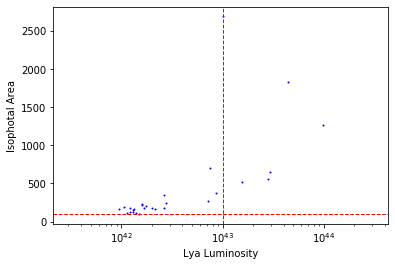

In [238]:
plt.semilogx()
plt.scatter(lya_luminosity,area_select, color = 'b', s=1)
plt.axhline(100, color='r', linestyle='--', linewidth = 1)
plt.axvline(1e43, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [239]:
x_final=[]
y_final=[]
ra_final=[]
dec_final=[]
mag_nb_final=[]
mag_bw_final=[]

for i in range(len(x_select)):
    if (lya_luminosity[i]> 1e43) and (area_select[i]> 100):
        x_final.append(x_select[i])
        y_final.append(y_select[i])
        ra_final.append(ra_select[i])
        dec_final.append(dec_select[i])
        mag_nb_final.append(mag_nb_select[i])
        mag_bw_final.append(mag_bw_select[i])
print(len(x_final))

6


x_image: 3950.3606 

y_image: 2520.9619 

RA: 220.2701367 

DEC: 39.900719 

nb_magnitude 20.106105839999998 

bw_magnitude: 22.187780840000002 



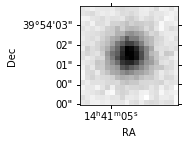

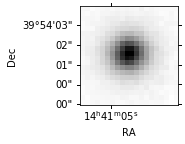

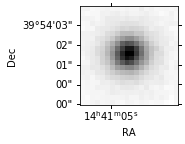

In [240]:
show_nebula(data,data2,datacut,x_final[0],y_final[0],10)
print('x_image:',x_final[0],'\n')
print('y_image:',y_final[0],'\n')
print('RA:',ra_final[0],'\n')
print('DEC:',dec_final[0],'\n')
print('nb_magnitude',mag_nb_final[0],'\n')
print('bw_magnitude:', mag_bw_final[0],'\n')

x_image: 4670.1973 

y_image: 2543.1631 

RA: 220.2049714 

DEC: 39.9021511 

nb_magnitude 19.41370584 

bw_magnitude: 20.74778084 



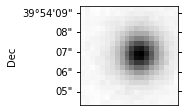

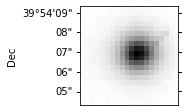

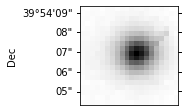

In [241]:
show_nebula(data,data2,datacut,x_final[1],y_final[1],10)
print('x_image:',x_final[1],'\n')
print('y_image:',y_final[1],'\n')
print('RA:',ra_final[1],'\n')
print('DEC:',dec_final[1],'\n')
print('nb_magnitude',mag_nb_final[1],'\n')
print('bw_magnitude:', mag_bw_final[1],'\n')

x_image: 2618.7688 

y_image: 4361.5669 

RA: 220.39059440000003 

DEC: 40.0286453 

nb_magnitude 19.654905839999998 

bw_magnitude: 20.63788084 



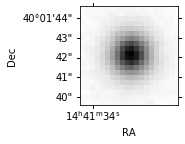

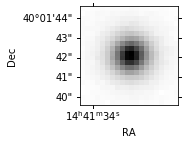

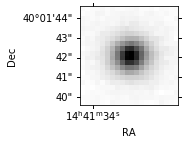

In [242]:
show_nebula(data,data2,datacut,x_final[2],y_final[2],10)
print('x_image:',x_final[2],'\n')
print('y_image:',y_final[2],'\n')
print('RA:',ra_final[2],'\n')
print('DEC:',dec_final[2],'\n')
print('nb_magnitude',mag_nb_final[2],'\n')
print('bw_magnitude:', mag_bw_final[2],'\n')

x_image: 3050.3345 

y_image: 4711.5024 

RA: 220.3514259 

DEC: 40.0529253 

nb_magnitude 21.25380584 

bw_magnitude: 23.65808084 



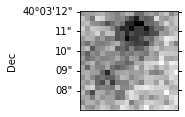

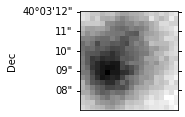

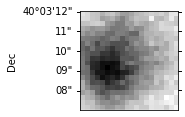

In [243]:
show_nebula(data,data2,datacut,x_final[3],y_final[3],10)
print('x_image:',x_final[3],'\n')
print('y_image:',y_final[3],'\n')
print('RA:',ra_final[3],'\n')
print('DEC:',dec_final[3],'\n')
print('nb_magnitude',mag_nb_final[3],'\n')
print('bw_magnitude:', mag_bw_final[3],'\n')

x_image: 2686.3586 

y_image: 5533.7007 

RA: 220.38440609999998 

DEC: 40.1100408 

nb_magnitude 20.56720584 

bw_magnitude: 21.94158084 



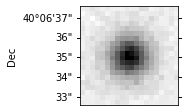

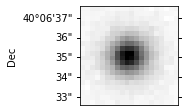

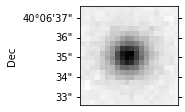

In [244]:
show_nebula(data,data2,datacut,x_final[4],y_final[4],10)
print('x_image:',x_final[4],'\n')
print('y_image:',y_final[4],'\n')
print('RA:',ra_final[4],'\n')
print('DEC:',dec_final[4],'\n')
print('nb_magnitude',mag_nb_final[4],'\n')
print('bw_magnitude:', mag_bw_final[4],'\n')

x_image: 5633.9624 

y_image: 6787.417 

RA: 220.1163631 

DEC: 40.196681700000006 

nb_magnitude 18.472005839999998 

bw_magnitude: 19.64838084 



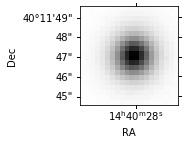

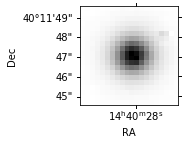

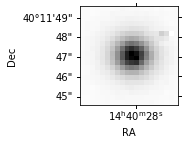

In [245]:
show_nebula(data,data2,datacut,x_final[5],y_final[5],10)
print('x_image:',x_final[5],'\n')
print('y_image:',y_final[5],'\n')
print('RA:',ra_final[5],'\n')
print('DEC:',dec_final[5],'\n')
print('nb_magnitude',mag_nb_final[5],'\n')
print('bw_magnitude:', mag_bw_final[5],'\n')

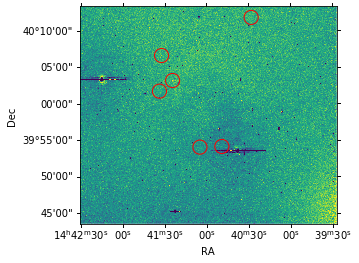

<Figure size 432x288 with 0 Axes>

In [246]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(x_final, y_final, color='', marker='o', edgecolors='r', s=200)

In [247]:
with open("BOSS1441_cut.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(x_select)):
        txtfile.write('circle(')
        txtfile.write(str(ra_select[i]))
        txtfile.write(',')
        txtfile.write(str(dec_select[i]))
        txtfile.write(',2.821")\n')